In [1]:
import bisect
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import *

<br>

# Motivation: evaluating expected values
---

We will often be interested in evaluating the expectation of some function $f$, such that there are no known closed form for:

&emsp; $\displaystyle E[f] = \int f(x) p(x) dx$

The simple approach we can use in such cases is to draw samples $(x_1 \dots x_L)$ from $p(x)$ and do a sample average of the values $f(x_1) \dots f(x_L)$ obtained:

&emsp; $\displaystyle \hat{f} = \frac{1}{L} \sum_l f(x_l)$
&emsp; $\implies$
&emsp; $\displaystyle E[\hat{f}] = \frac{1}{L} \sum_l E[f] = E[f]$
&emsp; and
&emsp; $\displaystyle \sigma^2[\hat{f}] = \frac{\sigma^2[f]}{L}$

This is how we can easily estimate the mean and variance of a gaussian:

In [36]:
L = 5000
xs = np.random.normal(loc=0., scale=1., size=L)
print("Mean:", np.sum(xs) / L)
print("Variance:", np.sum(xs**2) / L)

Mean: -0.011014664411155931
Variance: 0.9953507703209511


<br>

# Basic: Inverse transform sampling
---

We have a random generator of number in uniform distribution $U(0,1)$ and we want to be able to model any distribution $p(y)$ such as gaussians, exponential distributions or discrete distribution. How can we do it?

<br>

### The intuition

The **cumulative density function** $C$ of a distribution $p(y)$ indicates what is the **probablity that the value takes a value below or equal to $y$**:

&emsp; $\displaystyle C(y) = \int_{-\infty}^{y} p(y) dy : \mathbb{R} \rightarrow [0,1]$
&emsp; $\implies$
&emsp; $\displaystyle C(y) = \int_{-\infty}^{\infty} p(y) dy = 1$
&emsp; $and$
&emsp; $\displaystyle \displaystyle p(y) = \frac{d}{dy} C(y)$

The CDF is a function that returns a results between O and 1. The value of the CDF changes rapidely when the probability density $p$ has a high value (since it is the derivate of the CDF). The CDF is also monotonously increasing.

So if we pick a number $z \sim U(0,1)$ from the codomain of $C$, and find the $y$ in the domain of $C$ such that $C(y) = z$, we have a higher change of falling on $y$ for which $p(y)$ is high. This phenomena is illustrated below:

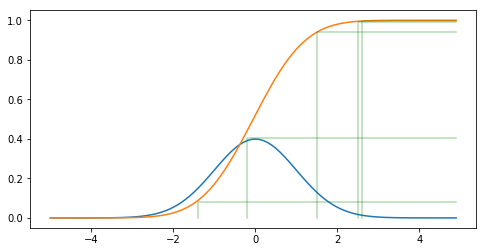

In [2]:
dy = 0.1
ys = np.arange(-5., 5., dy)
ps = np.exp(- ys ** 2 / 2) / math.sqrt(2 * math.pi)
cs = np.cumsum(ps) * dy

plt.figure(figsize=(8,4))
plt.plot(ys, ps)
plt.plot(ys, cs)
for z in np.random.uniform(0., 1., size=5):
    y = ys[bisect.bisect_left(cs, z)]
    plt.plot([y,y,np.max(ys)],[0,z,z], color='green', alpha=0.3)
plt.show()

<br>

### The technique

To sample a $y$, we therefore sample a $z \sim U(0,1)$, and then solve:

&emsp; $C(y) = z$
&emsp; $\implies$
&emsp; $y = C_y^{-1}(z)$
&emsp; where
&emsp; $C_y$ is the cumulative distribution function of $y$

This formula can be generalized by observing that if we pose $z = C_y(y)$, the derivative of $C(y)$ is $dz/dy$ which is also equal to $p(y)$ by definition of the cumulative distribution function. So if we have two distributions $p(x)$ and $p(y)$ we can write:

&emsp; $\displaystyle \frac{dz}{dy} = p(y)$
&emsp; and
&emsp; $\displaystyle \frac{dz}{dx} = p(x)$
&emsp; $\implies$
&emsp; $dz = p(y) dy = p(x) dx$
&emsp; $\implies$
&emsp; $\displaystyle p(y) = p(x) \frac{dx}{dy}$

So if we know how the density function $p(x)$ and we know how to express $y$ as a function of $x$, such that $y = f(x)$, we can deduce the distribution of $y$. Similarly, if we know how to sample $x$, we can also sample $y$. The formulas are summarized below:

&emsp; $y = f(x)$
&emsp; $\implies$
&emsp; $\displaystyle \boxed{p(y) = p(x) \frac{dx}{dy}}$
&emsp; and
&emsp; $\text{to sample }y: \; \boxed{\text{sample }x \sim p(x)\text{ and apply }y = C_y^{-1}(C_x(x))}$

This technique works as long as you can efficiently reverse the cumulative density function, which is limited to a restricted set of probability distributions. For instance, we cannot use this method to sample from $y \sim \mathcal{N}(\mu,\sigma^2)$ as there is **no closed form for the indefinite integral of the normal probability density function**.

<br>

### Examples

We want to sample elements from $y \sim U(1,3)$:

&emsp; $\displaystyle p(y) = \frac{1}{2}$
&emsp; $\implies$
&emsp; $\displaystyle C(y) = \int_1^y \frac{1}{2} dy = \frac{1}{2}(y-1)$
&emsp; $\implies$
&emsp; $\displaystyle \frac{1}{2}(y-1) = z$
&emsp; $\implies$
&emsp; $y = 2 z + 1$

We want to sample elements from $t \sim exp(\lambda)$:

&emsp; $\displaystyle p(t) = \lambda^{- \lambda t}$
&emsp; $\implies$
&emsp; $\displaystyle C(t) = \int_{-\infty}^t \lambda e^{-\lambda t} dt = \big[ -e^{-\lambda t} \big]_{-\infty}^t = 1 - e^{-\lambda t} = z$
&emsp; $\implies$
&emsp; $\displaystyle t = - \frac{\log (1 - z)}{\lambda}$

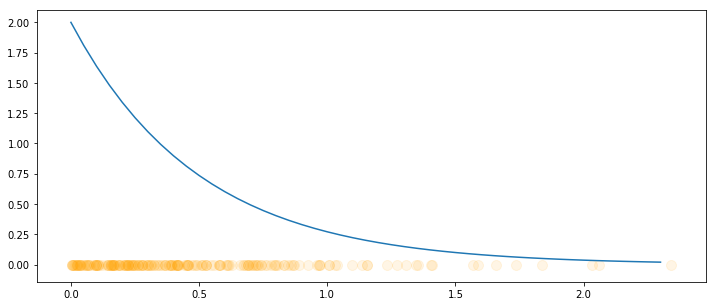

In [3]:
def sample_exp(lam: float, size: int):
    zs = np.random.uniform(0., 1., size=size)
    return - np.log(1 - zs) / lam

samples = sample_exp(2., 200)
ts = np.arange(0., np.max(samples), 0.05)

plt.figure(figsize=(12,5))
plt.plot(ts, 2. * np.exp(-2. * ts))
plt.scatter(samples, [0]*len(samples),s=100, alpha=0.1, color='orange')
plt.show()

<br>

# Rejection sampling and Importance sampling
---

In case we do not have a way to do inverse transform sampling, we have two techniques that work for well for **univariate distributions** that make use of an approximate distributions $q(z)$ that is ideally really close to $p(z)$.

<br>

### Hypotheses for both methods

**Hypothesis 1**: Although we have no easy way to sample from $p$, it is easy for us to get a value for a specific $p(z)$. This often happen when doing Density Estimations. In such cases, we might have a kernel estimation of the density, which gives us a way to get the probability for a given sample $z$, but we do not have easy ways to sample from this distribution.

**Hypothesis 2**: Although we have no easy way to sample from $p$, we have an easy way to sample from a distribution $q$ such that:

* $p(z) \ne 0 \implies q(z) \ne 0$
* $\forall z$, $q(z)$ is not far away from $p(z)$

**Personnal note:** We might be interested in evaluating the KL divergence of $q$ with respect to $p$, but it gives the wrong sense of priority (since it pushes $q(x)$ to be zero when $p(x)$ is zero, but not the other way around):

&emsp; $\displaystyle D_{KL}(q||p) = - \int q(x) \log \frac{p(x)}{q(x)} dx$

The KL divergence in the other direction would be more interesting but cannot be evaluated since we do not know how to sample from $p(x)$. In short, the KL divergence is of no help here.

<br>

### Rejection sampling

The idea behind rejection sampling is to find a constant $k$ such that $k q(z) \ge p(z)$, and to sample two number at each trial:

* a sample $z \sim q$
* a sample $v \sim U(0, kq(z))$

The idea is then to reject the sample $z$ if $v > p(z)$. This can be easily illustrated by the following drawing, in which we sample from $q(z)$ but only keep the points that fall the in green era below value of $p(z)$, and reject those sample that falls in the gray area:

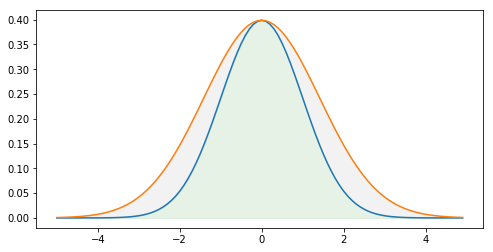

In [51]:
xs = np.arange(-5., 5., 0.1)
ps = np.exp(-xs ** 2 / 2) / math.sqrt(2 * math.pi * 1)
qs = np.exp(-xs ** 2 / 4) / math.sqrt(2 * math.pi * 2)
k = math.sqrt(2) # square root of the ratio of variances
plt.figure(figsize=(8,4))
plt.plot(xs, ps)
plt.plot(xs, k * qs)
plt.fill_between(xs, ps, [0] * len(ps), alpha=0.1, color='green')
plt.fill_between(xs, ps, k * qs, alpha=0.1, color='grey')
plt.show()

<br>

### Importance sampling

The idea behind importance sampling is to avoid rejecting samples, but instead discount them. It means that importance sampling **can only be used to evaluate an expectation, and not to simply draw samples**. It follows from a simple algebraic manipulations

&emsp; $\displaystyle E[f] = \int f(x) p(x) dx = \int \Big(f(x) \frac{p(x)}{q(x)}\Big) q(x) dx$

So each time we draw a sample $z \sim q$, we evaluate the ratio of probabilities $p(z) / q(z)$ and multiply the value of $f(z)$ by this ratio before taking it into account in the sample average.

<br>

### Issues with both models

These approaches **do not work well for multivariate distributions**, as a consequence of the curse of dimensionality: gap between $q$ and $p$ becomes more prevalent as the dimensions increases. There are mostly used as **building blocks** for these complex distributions, often by allowing to sample from a **conditional univariate distribution**, for example to sample from $p(x_i|{x}_{j \ne i})$.

These approaches also have issues based on the difficulty of finding a suitable $q$ that is close to $p$. These issues are circumvented through other techniques such as **adaptative rejection sampling** which creates a **convex hull** around the distribution $p$ that shrinks as the number of samples gets higher.